In [1]:
model_path='logs/可以用.h5'

In [2]:
file_path = "data//VOC2007//samples//img243.jpg"

In [3]:
import warnings

warnings.filterwarnings('ignore')

def multi_gpu_model(model, gpus=None):
    
    if K.backend() != 'tensorflow':
        raise ValueError('`multi_gpu_model` is only available '
                         'with the TensorFlow backend.')

    available_devices = _get_available_devices()
    available_devices = [_normalize_device_name(name) for name in available_devices]
    if not gpus:
        # Using all visible GPUs when not specifying `gpus`
        # e.g. CUDA_VISIBLE_DEVICES=0,2 python3 keras_mgpu.py
        gpus = len([x for x in available_devices if 'gpu' in x])

    if isinstance(gpus, (list, tuple)):
        if len(gpus) <= 1:
            raise ValueError('For multi-gpu usage to be effective, '
                             'call `multi_gpu_model` with `len(gpus) >= 2`. '
                             'Received: `gpus=%s`' % gpus)
        num_gpus = len(gpus)
        target_gpu_ids = gpus
    else:
        if gpus <= 1:
            raise ValueError('For multi-gpu usage to be effective, '
                             'call `multi_gpu_model` with `gpus >= 2`. '
                             'Received: `gpus=%d`' % gpus)
        num_gpus = gpus
        target_gpu_ids = range(num_gpus)

    import tensorflow as tf

    target_devices = ['/cpu:0'] + ['/gpu:%d' % i for i in target_gpu_ids]
    for device in target_devices:
        if device not in available_devices:
            raise ValueError(
                'To call `multi_gpu_model` with `gpus=%d`, '
                'we expect the following devices to be available: %s. '
                'However this machine only has: %s. '
                'Try reducing `gpus`.' % (gpus,
                                          target_devices,
                                          available_devices))

    def get_slice(data, i, parts):
        shape = tf.shape(data)
        batch_size = shape[:1]
        input_shape = shape[1:]
        step = batch_size // parts
        if i == num_gpus - 1:
            size = batch_size - step * i
        else:
            size = step
        size = tf.concat([size, input_shape], axis=0)
        stride = tf.concat([step, input_shape * 0], axis=0)
        start = stride * i
        return tf.slice(data, start, size)

    all_outputs = []
    for i in range(len(model.outputs)):
        all_outputs.append([])

    # Place a copy of the model on each GPU,
    # each getting a slice of the inputs.
    for i, gpu_id in enumerate(target_gpu_ids):
        with tf.device('/gpu:%d' % gpu_id):
            with tf.name_scope('replica_%d' % gpu_id):
                inputs = []
                # Retrieve a slice of the input.
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_i = Lambda(get_slice,
                                     output_shape=input_shape,
                                     arguments={'i': i,
                                                'parts': num_gpus})(x)
                    inputs.append(slice_i)

                # Apply model on slice
                # (creating a model replica on the target device).
                outputs = model(inputs)
                if not isinstance(outputs, list):
                    outputs = [outputs]

                # Save the outputs for merging back together later.
                for o in range(len(outputs)):
                    all_outputs[o].append(outputs[o])

    # Merge outputs on CPU.
    with tf.device('/cpu:0'):
        merged = []
        for name, outputs in zip(model.output_names, all_outputs):
            merged.append(add(outputs, name=name))
        return Model(model.inputs, merged)

# -*- coding: utf-8 -*-
"""
Class definition of YOLO_v3 style detection model on image and video
"""

import colorsys
import os
from timeit import default_timer as timer

import numpy as np
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image
import os
#from keras.utils import multi_gpu_model

list_pic=[]
list_box=[]


class YOLO(object):
    _defaults = {
        "model_path": model_path,
        "anchors_path": 'model_data/yolo_anchors.txt',
        "classes_path": 'model_data/voc_classes.txt',
        "score" : 0.3,
        "iou" : 0.45,
        "model_image_size" : (416, 416),
        "gpu_num" : 1,
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path, encoding='utf8') as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path, encoding='utf8') as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes

    def detect_image(self, image):
        start = timer()

        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })
        list_box.append(len(out_boxes))
        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        font = ImageFont.truetype(font='font/msjh.ttc',
                    size=np.floor(3e-2 * 380 + 0.5).astype('int32'))
        thickness = (image.size[0] + image.size[1]) // 300

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            
            list_list = [label, 'y:(top, bottom)',(top, bottom),'x:(left, right)', (left, right),'IOU值:',score]
            list_pic.append(list_list)
            print(label, 'y:(top, bottom)',(top, bottom),'x:(left, right)', (left, right))
            
            
            
            
            
            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            #for i in range(thickness):
                #draw.rectangle(
                    #[left + i, top + i, right - i, bottom - i],
                    #outline=self.colors[c])
            #draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)],fill=self.colors[c])
            #draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            
            # My kingdom for a good redistributable image drawing library.
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)],fill=self.colors[c])
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            
                   
            
            
            
            del draw

        end = timer()
        print(end - start)
        return image

    def close_session(self):
        self.sess.close()

Using TensorFlow backend.


In [4]:
class YOLO2(object):
    _defaults = {
        "model_path":model_path ,
        "anchors_path": 'model_data/yolo_anchors.txt',
        "classes_path": 'model_data/voc_classes.txt',
        "score" : 0.3,
        "iou" : 0.45,
        "model_image_size" : (416, 416),
        "gpu_num" : 1,
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path, encoding='utf8') as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path, encoding='utf8') as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes

    def detect_image(self, image):
        start = timer()

        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })
        list_box2.append(len(out_boxes))
        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        font = ImageFont.truetype(font='font/msjh.ttc',
                    size=np.floor(3e-2 * 380 + 0.5).astype('int32'))
        thickness = (image.size[0] + image.size[1]) // 300

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            
            list_list2 = [label, 'y:(top, bottom)',(top, bottom),'x:(left, right)', (left, right),'IOU值:',score]
            list_pic2.append(list_list2)
            print(label, 'y:(top, bottom)',(top, bottom),'x:(left, right)', (left, right))
            
            
            
            
            
            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            #for i in range(thickness):
                #draw.rectangle(
                    #[left + i, top + i, right - i, bottom - i],
                    #outline=self.colors[c])
            #draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)],fill=self.colors[c])
            #draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            
            # My kingdom for a good redistributable image drawing library.
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)],fill=self.colors[c])
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            
                   
            
            
            
            del draw

        end = timer()
        print(end - start)
        return image

    def close_session(self):
        self.sess.close()

In [5]:
from PIL import Image
import sys
import matplotlib.pyplot as plt
import numpy as np 
import cv2
import pylab
from PIL import Image, ImageDraw, ImageFont

In [6]:

image = Image.open(file_path)
img = cv2.imread(file_path)

In [7]:
img_size=img.shape
img_size_width=img_size[1]
img_size_hight=img_size[0]
img_size_width_CUT=img_size_width//2
img_size_hight_CUT=img_size_hight//2

In [8]:
img_size_width_CUT

256

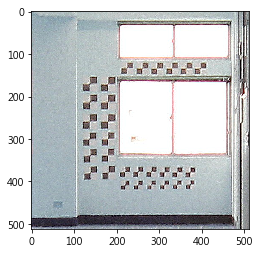

In [9]:
plt.imshow(img)
plt.show()

In [10]:
img_LT_coordinate = [0,img_size_width_CUT,0,img_size_hight_CUT]
img_LB_coordinate = [0,img_size_width_CUT,img_size_hight_CUT,img_size_hight_CUT+img_size_hight_CUT]


img_RT_coordinate = [img_size_width_CUT,img_size_width_CUT+img_size_width_CUT,0,img_size_hight_CUT]
img_RB_coordinate = [img_size_width_CUT,img_size_width,img_size_hight_CUT,img_size_hight]

all_img=img_LT_coordinate,img_LB_coordinate,img_RT_coordinate,img_RB_coordinate

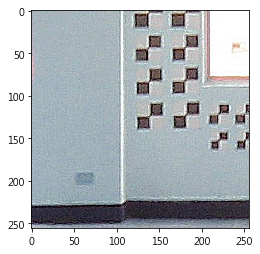

In [11]:
LT = img_LT_coordinate
RT = img_RT_coordinate
LB = img_LB_coordinate
RB = img_RB_coordinate
crop_img_LT = img[LT[2]:LT[3], LT[0]:LT[1]]

crop_img_RT = img[RT[2]:RT[3],RT[0]:RT[1] ]

crop_img_LB = img[LB[2]:LB[3], LB[0]:LB[1]]
crop_img_RB = img[RB[2]:RB[3], RB[0]:RB[1]]
plt.imshow(crop_img_LB )
plt.show()

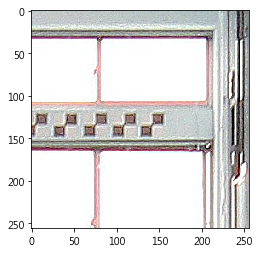

In [12]:
plt.imshow(crop_img_RT )
plt.show()

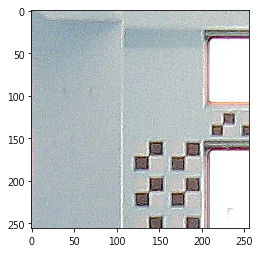

In [13]:
plt.imshow(crop_img_LT )
plt.show()

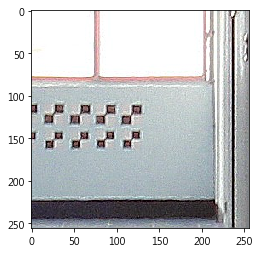

In [14]:
plt.imshow(crop_img_RB )
plt.show()

# 4.將分割的照片從np格式轉成img格式

In [15]:
crop_img_LT_copy=crop_img_LT
crop_img_LT_plt = Image.fromarray(crop_img_LT_copy)

crop_img_RT_copy=crop_img_RT
crop_img_RT_plt = Image.fromarray(crop_img_RT_copy)

crop_img_LB_copy=crop_img_LB
crop_img_LB_plt = Image.fromarray(crop_img_LB_copy)

crop_img_RB_copy=crop_img_RB
crop_img_RB_plt = Image.fromarray(crop_img_RB_copy)

# 5.透過訓練好的yolo來辨識分割照片的座標

In [16]:
def detect_img(yolo):
    time=0
    for time in range(1):
        time+=1
        
        #img = 'data//VOC2007//samples//IMG_1649.jpg'
        img =  file_path
        img2 = cv2.imread(img)
        
        try:
            image1 = crop_img_LT_plt
            image2 = crop_img_RT_plt
            image3 = crop_img_LB_plt
            image4 = crop_img_RB_plt
            img2 = Image.fromarray(img2)
            #image5 = Image.open(img)
        except:
            print('Open Error! Try again!')
            continue            
            
        else:
            r_image1 = yolo.detect_image(image1)
            r_image1.show()
            r_image2 = yolo.detect_image(image2)
            r_image2.show()
            r_image3 = yolo.detect_image(image3)
            r_image3.show()
            r_image4 = yolo.detect_image(image4)
            r_image4.show()
            
            r_image5 = yolo.detect_image(img2)
            r_image5.show()
            r_image5.save('img_51.png', quality=90)
            #r_image.save('img.png', quality=90)
            #yolo.close_session()
            


if __name__ == '__main__':
    detect_img(YOLO())

logs/可以用.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 8 boxes for img
方標 0.31 y:(top, bottom) (244, 256) x:(left, right) (114, 158)
方標 0.38 y:(top, bottom) (120, 150) x:(left, right) (248, 256)
方標 0.85 y:(top, bottom) (241, 256) x:(left, right) (160, 198)
方標 0.88 y:(top, bottom) (121, 148) x:(left, right) (211, 240)
方標 0.99 y:(top, bottom) (195, 232) x:(left, right) (120, 157)
方標 0.99 y:(top, bottom) (153, 190) x:(left, right) (162, 200)
方標 0.99 y:(top, bottom) (152, 189) x:(left, right) (119, 157)
方標 1.00 y:(top, bottom) (195, 232) x:(left, right) (163, 200)
2.7690079
(416, 416, 3)
Found 5 boxes for img
方標 0.90 y:(top, bottom) (120, 150) x:(left, right) (0, 24)
方標 0.94 y:(top, bottom) (120, 149) x:(left, right) (128, 158)
方標 0.95 y:(top, bottom) (119, 149) x:(left, right) (96, 123)
方標 0.97 y:(top, bottom) (121, 148) x:(left, right) (61, 91)
方標 0.99 y:(top, bottom) (121, 148) x:(left, right) (26, 55)
0.07471840000000007
(416, 416, 3)
Found 11 boxes for img
方標 0.46 y:(top,

In [17]:
list_pic

[['方標 0.31',
  'y:(top, bottom)',
  (244, 256),
  'x:(left, right)',
  (114, 158),
  'IOU值:',
  0.30855483],
 ['方標 0.38',
  'y:(top, bottom)',
  (120, 150),
  'x:(left, right)',
  (248, 256),
  'IOU值:',
  0.3840634],
 ['方標 0.85',
  'y:(top, bottom)',
  (241, 256),
  'x:(left, right)',
  (160, 198),
  'IOU值:',
  0.84627247],
 ['方標 0.88',
  'y:(top, bottom)',
  (121, 148),
  'x:(left, right)',
  (211, 240),
  'IOU值:',
  0.8828447],
 ['方標 0.99',
  'y:(top, bottom)',
  (195, 232),
  'x:(left, right)',
  (120, 157),
  'IOU值:',
  0.9907515],
 ['方標 0.99',
  'y:(top, bottom)',
  (153, 190),
  'x:(left, right)',
  (162, 200),
  'IOU值:',
  0.9919604],
 ['方標 0.99',
  'y:(top, bottom)',
  (152, 189),
  'x:(left, right)',
  (119, 157),
  'IOU值:',
  0.994632],
 ['方標 1.00',
  'y:(top, bottom)',
  (195, 232),
  'x:(left, right)',
  (163, 200),
  'IOU值:',
  0.9972393],
 ['方標 0.90',
  'y:(top, bottom)',
  (120, 150),
  'x:(left, right)',
  (0, 24),
  'IOU值:',
  0.90448654],
 ['方標 0.94',
  'y:(top, botto

# YOLO有被切到的目標

In [18]:
YOLO_ALL_object=[]

In [19]:
for yolo_ob in list_pic:
    if yolo_ob[2][0] <img_size_hight_CUT and yolo_ob[2][1] >img_size_hight_CUT:
        YOLO_ALL_object.append(yolo_ob)
    elif yolo_ob[4][0] <img_size_width_CUT and yolo_ob[4][1] >img_size_width_CUT:
        YOLO_ALL_object.append(yolo_ob)
        
    

In [20]:
YOLO_ALL_object

[['方標 0.39',
  'y:(top, bottom)',
  (243, 280),
  'x:(left, right)',
  (118, 155),
  'IOU值:',
  0.39039811],
 ['方標 0.56',
  'y:(top, bottom)',
  (395, 421),
  'x:(left, right)',
  (239, 264),
  'IOU值:',
  0.5634485],
 ['方標 0.64',
  'y:(top, bottom)',
  (243, 283),
  'x:(left, right)',
  (162, 199),
  'IOU值:',
  0.64007634],
 ['方標 0.69',
  'y:(top, bottom)',
  (363, 391),
  'x:(left, right)',
  (239, 264),
  'IOU值:',
  0.68634695],
 ['方標 0.76',
  'y:(top, bottom)',
  (118, 150),
  'x:(left, right)',
  (246, 276),
  'IOU值:',
  0.7602251]]

In [21]:
left_list_range=[]
right_list_range=[]
top_list_range=[]
bottom_list_range=[]

In [22]:
for YOLO_range in YOLO_ALL_object:
    top_list_range.append(YOLO_range[2][0])
    bottom_list_range.append(YOLO_range[2][1])
    left_list_range.append(YOLO_range[4][0])
    right_list_range.append(YOLO_range[4][1])

In [23]:
left_list_range

[118, 239, 162, 239, 246]

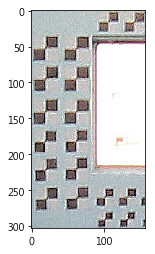

In [24]:
min_left=min(left_list_range, default=0)
min_right=max(right_list_range, default=0)
min_top=min(top_list_range, default=0)
min_bottom=max(bottom_list_range, default=0)
crop_img_yolo = img[min_top:min_bottom, min_left:min_right]

plt.imshow(crop_img_yolo )
plt.show()

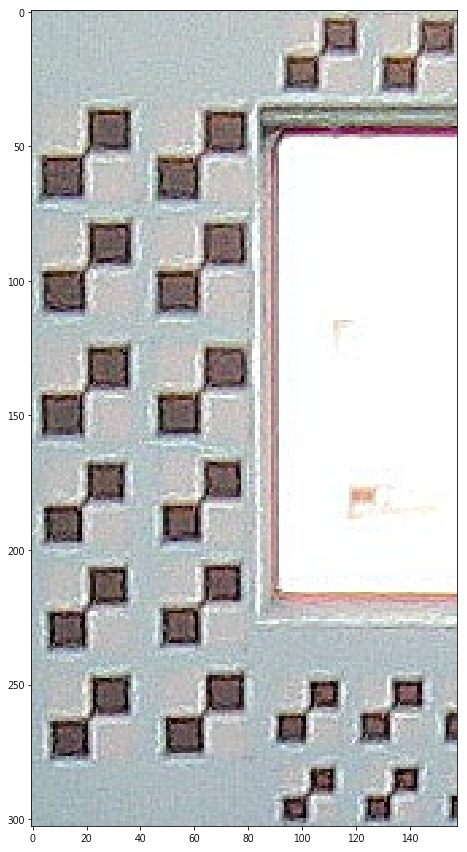

In [25]:
px=0

min_left=min(left_list_range, default=0)
min_right=max(right_list_range, default=0)
min_top=min(top_list_range, default=0)
min_bottom=max(bottom_list_range, default=0)
crop_img_yolo = img[min_top-px:min_bottom+px, min_left:min_right+px]
plt.figure('hist',figsize=(15,15))
plt.imshow(crop_img_yolo )
plt.show()

In [26]:
crop_img_yolo_copy=crop_img_yolo
crop_img_yolo_plt = Image.fromarray(crop_img_yolo_copy)

In [27]:
crop_img_yolo

array([[[186, 200, 199],
        [176, 190, 189],
        [178, 191, 193],
        ...,
        [194, 198, 187],
        [203, 208, 199],
        [195, 200, 191]],

       [[184, 198, 197],
        [179, 193, 192],
        [181, 194, 196],
        ...,
        [195, 198, 183],
        [206, 210, 198],
        [192, 199, 186]],

       [[183, 197, 196],
        [172, 186, 185],
        [184, 197, 199],
        ...,
        [217, 215, 197],
        [194, 195, 179],
        [180, 185, 170]],

       ...,

       [[158, 173, 182],
        [163, 178, 187],
        [147, 165, 172],
        ...,
        [129, 138, 152],
        [ 99, 104, 119],
        [154, 152, 171]],

       [[164, 179, 188],
        [166, 182, 189],
        [167, 185, 192],
        ...,
        [140, 153, 169],
        [160, 168, 185],
        [178, 182, 201]],

       [[166, 181, 190],
        [170, 186, 193],
        [170, 186, 193],
        ...,
        [167, 186, 194],
        [173, 187, 199],
        [193, 205, 217]]

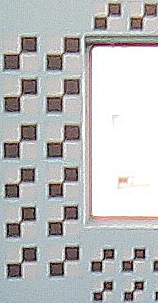

In [28]:
crop_img_yolo_plt

In [29]:
list_pic2=[]
list_box2=[]

In [30]:
def detect_img2(yolo2):
    time=0
    for time in range(1):
        time+=1
        
        #img = 'data//VOC2007//samples//IMG_1649.jpg'
        #img =  file_path
        #img2 = cv2.imread(img)
        
        try:
            image6 = crop_img_yolo_plt
            
        except:
            print('Open Error! Try again!')
            continue            
            
        else:
            r_image1 = yolo2.detect_image(image6)
            r_image1.show()
            #r_image1.save('img_yolocut.png', quality=90)
            #r_image5.save('img_51.png', quality=90)
            #r_image.save('img.png', quality=90)
            #yolo2.close_session()


if __name__ == '__main__':
    detect_img2(YOLO2())            

logs/可以用.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 18 boxes for img
方標 0.44 y:(top, bottom) (203, 237) x:(left, right) (6, 37)
方標 0.56 y:(top, bottom) (33, 72) x:(left, right) (1, 39)
方標 0.62 y:(top, bottom) (78, 113) x:(left, right) (4, 38)
方標 0.64 y:(top, bottom) (124, 158) x:(left, right) (2, 38)
方標 0.69 y:(top, bottom) (1, 31) x:(left, right) (128, 158)
方標 0.71 y:(top, bottom) (3, 30) x:(left, right) (92, 123)
方標 0.75 y:(top, bottom) (278, 302) x:(left, right) (121, 144)
方標 0.77 y:(top, bottom) (167, 199) x:(left, right) (5, 38)
方標 0.80 y:(top, bottom) (124, 158) x:(left, right) (45, 80)
方標 0.80 y:(top, bottom) (36, 71) x:(left, right) (46, 81)
方標 0.85 y:(top, bottom) (166, 199) x:(left, right) (46, 79)
方標 0.87 y:(top, bottom) (278, 302) x:(left, right) (90, 116)
方標 0.87 y:(top, bottom) (206, 235) x:(left, right) (46, 80)
方標 0.91 y:(top, bottom) (79, 112) x:(left, right) (45, 81)
方標 0.91 y:(top, bottom) (245, 279) x:(left, right) (5, 39)
方標 0.93 y:(top, bottom) (24

In [31]:
crop_img_LT_list = list_pic[0:list_box[0]]
crop_img_RT_list = list_pic[list_box[0]:list_box[0]+list_box[1]]
crop_img_LB_list = list_pic[list_box[0]+list_box[1]:list_box[0]+list_box[1]+list_box[2]]
crop_img_RB_list = list_pic[list_box[0]+list_box[1]+list_box[2]:list_box[0]+list_box[1]+list_box[2]+list_box[3]]

In [32]:
crop_img_LT_list

[['方標 0.31',
  'y:(top, bottom)',
  (244, 256),
  'x:(left, right)',
  (114, 158),
  'IOU值:',
  0.30855483],
 ['方標 0.38',
  'y:(top, bottom)',
  (120, 150),
  'x:(left, right)',
  (248, 256),
  'IOU值:',
  0.3840634],
 ['方標 0.85',
  'y:(top, bottom)',
  (241, 256),
  'x:(left, right)',
  (160, 198),
  'IOU值:',
  0.84627247],
 ['方標 0.88',
  'y:(top, bottom)',
  (121, 148),
  'x:(left, right)',
  (211, 240),
  'IOU值:',
  0.8828447],
 ['方標 0.99',
  'y:(top, bottom)',
  (195, 232),
  'x:(left, right)',
  (120, 157),
  'IOU值:',
  0.9907515],
 ['方標 0.99',
  'y:(top, bottom)',
  (153, 190),
  'x:(left, right)',
  (162, 200),
  'IOU值:',
  0.9919604],
 ['方標 0.99',
  'y:(top, bottom)',
  (152, 189),
  'x:(left, right)',
  (119, 157),
  'IOU值:',
  0.994632],
 ['方標 1.00',
  'y:(top, bottom)',
  (195, 232),
  'x:(left, right)',
  (163, 200),
  'IOU值:',
  0.9972393]]

In [33]:
crop_img_RB_list

[['方標 0.51',
  'y:(top, bottom)',
  (107, 135),
  'x:(left, right)',
  (0, 8),
  'IOU值:',
  0.51400304],
 ['方標 0.56',
  'y:(top, bottom)',
  (140, 163),
  'x:(left, right)',
  (0, 7),
  'IOU值:',
  0.5587331],
 ['方標 0.65',
  'y:(top, bottom)',
  (140, 164),
  'x:(left, right)',
  (75, 101),
  'IOU值:',
  0.6495855],
 ['方標 0.78',
  'y:(top, bottom)',
  (140, 164),
  'x:(left, right)',
  (14, 40),
  'IOU值:',
  0.78007686],
 ['方標 0.86',
  'y:(top, bottom)',
  (137, 165),
  'x:(left, right)',
  (106, 130),
  'IOU值:',
  0.8600781],
 ['方標 0.89',
  'y:(top, bottom)',
  (141, 163),
  'x:(left, right)',
  (46, 69),
  'IOU值:',
  0.8881658],
 ['方標 0.93',
  'y:(top, bottom)',
  (109, 135),
  'x:(left, right)',
  (74, 101),
  'IOU值:',
  0.92643094],
 ['方標 0.96',
  'y:(top, bottom)',
  (109, 134),
  'x:(left, right)',
  (105, 132),
  'IOU值:',
  0.9602609],
 ['方標 0.99',
  'y:(top, bottom)',
  (108, 135),
  'x:(left, right)',
  (44, 71),
  'IOU值:',
  0.98651284],
 ['方標 0.99',
  'y:(top, bottom)',
  (107

In [34]:
crop_img_LB_list

[['方標 0.46',
  'y:(top, bottom)',
  (140, 165),
  'x:(left, right)',
  (208, 234),
  'IOU值:',
  0.4580108],
 ['方標 0.65',
  'y:(top, bottom)',
  (1, 21),
  'x:(left, right)',
  (118, 156),
  'IOU值:',
  0.6475813],
 ['方標 0.69',
  'y:(top, bottom)',
  (28, 61),
  'x:(left, right)',
  (121, 156),
  'IOU值:',
  0.693826],
 ['方標 0.73',
  'y:(top, bottom)',
  (1, 21),
  'x:(left, right)',
  (162, 200),
  'IOU值:',
  0.7335716],
 ['方標 0.77',
  'y:(top, bottom)',
  (107, 135),
  'x:(left, right)',
  (242, 256),
  'IOU值:',
  0.7713799],
 ['方標 0.91',
  'y:(top, bottom)',
  (67, 101),
  'x:(left, right)',
  (121, 156),
  'IOU值:',
  0.9081165],
 ['方標 0.94',
  'y:(top, bottom)',
  (108, 135),
  'x:(left, right)',
  (207, 234),
  'IOU值:',
  0.93990606],
 ['方標 0.96',
  'y:(top, bottom)',
  (27, 61),
  'x:(left, right)',
  (164, 198),
  'IOU值:',
  0.9561485],
 ['方標 0.97',
  'y:(top, bottom)',
  (66, 99),
  'x:(left, right)',
  (164, 199),
  'IOU值:',
  0.97051007],
 ['方標 0.99',
  'y:(top, bottom)',
  (107

## 將分割圖像轉為原本座標

In [35]:
#定義tuple可以可做改變
def list_add(a,b):
    c = []
    for i in range(len(a)):
        c.append(a[i]+b[i])
    return c

In [36]:
print('LB:')
for number,crop_img_LB_list_number in enumerate (crop_img_LB_list):
    crop_img_LB_list_number[2]= tuple(list_add(crop_img_LB_list_number[2],[img_size_hight_CUT,img_size_hight_CUT]))
    print(crop_img_LB_list_number)
print('RB:')
for numberRB,crop_img_RB_list_number in enumerate (crop_img_RB_list):
    crop_img_RB_list_number[2]= tuple(list_add(crop_img_RB_list_number[2],[img_size_hight_CUT,img_size_hight_CUT]))
    crop_img_RB_list_number[4]= tuple(list_add(crop_img_RB_list_number[4],[img_size_width_CUT,img_size_width_CUT]))
    print(crop_img_RB_list_number)
print('RT:')
for numberRT,crop_img_RT_list_number in enumerate (crop_img_RT_list):
    crop_img_RT_list_number[4]= tuple(list_add(crop_img_RT_list_number[4],[img_size_width_CUT,img_size_width_CUT]))
    print(crop_img_RT_list_number)

LB:
['方標 0.46', 'y:(top, bottom)', (396, 421), 'x:(left, right)', (208, 234), 'IOU值:', 0.4580108]
['方標 0.65', 'y:(top, bottom)', (257, 277), 'x:(left, right)', (118, 156), 'IOU值:', 0.6475813]
['方標 0.69', 'y:(top, bottom)', (284, 317), 'x:(left, right)', (121, 156), 'IOU值:', 0.693826]
['方標 0.73', 'y:(top, bottom)', (257, 277), 'x:(left, right)', (162, 200), 'IOU值:', 0.7335716]
['方標 0.77', 'y:(top, bottom)', (363, 391), 'x:(left, right)', (242, 256), 'IOU值:', 0.7713799]
['方標 0.91', 'y:(top, bottom)', (323, 357), 'x:(left, right)', (121, 156), 'IOU值:', 0.9081165]
['方標 0.94', 'y:(top, bottom)', (364, 391), 'x:(left, right)', (207, 234), 'IOU值:', 0.93990606]
['方標 0.96', 'y:(top, bottom)', (283, 317), 'x:(left, right)', (164, 198), 'IOU值:', 0.9561485]
['方標 0.97', 'y:(top, bottom)', (322, 355), 'x:(left, right)', (164, 199), 'IOU值:', 0.97051007]
['方標 0.99', 'y:(top, bottom)', (363, 396), 'x:(left, right)', (165, 200), 'IOU值:', 0.9869619]
['方標 0.99', 'y:(top, bottom)', (363, 398), 'x:(left, ri

In [37]:
for numberLT,crop_img_LT_list_number in enumerate (crop_img_LT_list):
    print(crop_img_LT_list_number)

['方標 0.31', 'y:(top, bottom)', (244, 256), 'x:(left, right)', (114, 158), 'IOU值:', 0.30855483]
['方標 0.38', 'y:(top, bottom)', (120, 150), 'x:(left, right)', (248, 256), 'IOU值:', 0.3840634]
['方標 0.85', 'y:(top, bottom)', (241, 256), 'x:(left, right)', (160, 198), 'IOU值:', 0.84627247]
['方標 0.88', 'y:(top, bottom)', (121, 148), 'x:(left, right)', (211, 240), 'IOU值:', 0.8828447]
['方標 0.99', 'y:(top, bottom)', (195, 232), 'x:(left, right)', (120, 157), 'IOU值:', 0.9907515]
['方標 0.99', 'y:(top, bottom)', (153, 190), 'x:(left, right)', (162, 200), 'IOU值:', 0.9919604]
['方標 0.99', 'y:(top, bottom)', (152, 189), 'x:(left, right)', (119, 157), 'IOU值:', 0.994632]
['方標 1.00', 'y:(top, bottom)', (195, 232), 'x:(left, right)', (163, 200), 'IOU值:', 0.9972393]


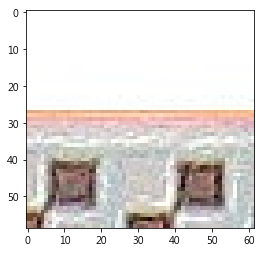

In [38]:
plt.imshow(img[81:140, 256:318] )
plt.show()

In [39]:
image1=image

In [40]:
CUT_LT=[]
CUT_LB=[]
CUT_RT=[]
CUT_RB=[]

In [41]:
for LT_ob in crop_img_LT_list:
    print(LT_ob)

['方標 0.31', 'y:(top, bottom)', (244, 256), 'x:(left, right)', (114, 158), 'IOU值:', 0.30855483]
['方標 0.38', 'y:(top, bottom)', (120, 150), 'x:(left, right)', (248, 256), 'IOU值:', 0.3840634]
['方標 0.85', 'y:(top, bottom)', (241, 256), 'x:(left, right)', (160, 198), 'IOU值:', 0.84627247]
['方標 0.88', 'y:(top, bottom)', (121, 148), 'x:(left, right)', (211, 240), 'IOU值:', 0.8828447]
['方標 0.99', 'y:(top, bottom)', (195, 232), 'x:(left, right)', (120, 157), 'IOU值:', 0.9907515]
['方標 0.99', 'y:(top, bottom)', (153, 190), 'x:(left, right)', (162, 200), 'IOU值:', 0.9919604]
['方標 0.99', 'y:(top, bottom)', (152, 189), 'x:(left, right)', (119, 157), 'IOU值:', 0.994632]
['方標 1.00', 'y:(top, bottom)', (195, 232), 'x:(left, right)', (163, 200), 'IOU值:', 0.9972393]


In [42]:
Cut_Pixel_Range=1

In [43]:
IoU=0.6

In [44]:
for LT_ob in crop_img_LT_list:
    if LT_ob[2][1] == img_size_hight_CUT-Cut_Pixel_Range or LT_ob[4][1] == img_size_width_CUT-Cut_Pixel_Range or LT_ob[6]<IoU:
        CUT_LT.append(LT_ob)
    elif LT_ob[2][1] == img_size_hight_CUT or LT_ob[4][1] == img_size_width_CUT :
        CUT_LT.append(LT_ob)
        
for LB_ob in crop_img_LB_list:
    if LB_ob[2][0] == img_size_hight_CUT-Cut_Pixel_Range or LB_ob[4][1] == img_size_hight_CUT-Cut_Pixel_Range or LB_ob[6]<IoU :
        CUT_LB.append(LB_ob)
    elif LB_ob[2][1] == img_size_hight_CUT or LB_ob[4][0] == img_size_width_CUT :
        CUT_LB.append(LB_ob)

        
for RT_ob in crop_img_RT_list:
    if RT_ob[4][0] == img_size_width_CUT+Cut_Pixel_Range or RT_ob[2][1] == img_size_hight_CUT-Cut_Pixel_Range or RT_ob[6]<IoU:
        CUT_RT.append(RT_ob)
    elif RT_ob[2][1] == img_size_hight_CUT or RT_ob[4][0] == img_size_width_CUT :
        CUT_RT.append(RT_ob) 

for RB_ob in crop_img_RB_list:
    if RB_ob[2][0] == img_size_hight_CUT+Cut_Pixel_Range or RB_ob[4][0] == img_size_width_CUT+Cut_Pixel_Range or RB_ob[6]<IoU:
        CUT_RB.append(RB_ob)
    elif RB_ob[2][1] == img_size_hight_CUT or RB_ob[4][0] == img_size_width_CUT :
        CUT_RB.append(RB_ob)     

In [45]:
CUT_LT


[['方標 0.31',
  'y:(top, bottom)',
  (244, 256),
  'x:(left, right)',
  (114, 158),
  'IOU值:',
  0.30855483],
 ['方標 0.38',
  'y:(top, bottom)',
  (120, 150),
  'x:(left, right)',
  (248, 256),
  'IOU值:',
  0.3840634],
 ['方標 0.85',
  'y:(top, bottom)',
  (241, 256),
  'x:(left, right)',
  (160, 198),
  'IOU值:',
  0.84627247]]

In [46]:
CUT_LB


[['方標 0.46',
  'y:(top, bottom)',
  (396, 421),
  'x:(left, right)',
  (208, 234),
  'IOU值:',
  0.4580108]]

In [47]:
CUT_RT


[['方標 0.90',
  'y:(top, bottom)',
  (120, 150),
  'x:(left, right)',
  (256, 280),
  'IOU值:',
  0.90448654]]

In [48]:
CUT_RB

[['方標 0.51',
  'y:(top, bottom)',
  (363, 391),
  'x:(left, right)',
  (256, 264),
  'IOU值:',
  0.51400304],
 ['方標 0.56',
  'y:(top, bottom)',
  (396, 419),
  'x:(left, right)',
  (256, 263),
  'IOU值:',
  0.5587331]]

In [49]:
for CUT_LT_CUT in CUT_LT:
    print(CUT_LT_CUT)
    crop_img_LT_list.remove(CUT_LT_CUT)
    
for CUT_LB_CUT in CUT_LB:
    print(CUT_LB_CUT)
    crop_img_LB_list.remove(CUT_LB_CUT) 
    
for CUT_RT_CUT in CUT_RT:
    print(CUT_RT_CUT)
    crop_img_RT_list.remove(CUT_RT_CUT)

for CUT_RB_CUT in CUT_RB:
    print(CUT_RB_CUT)
    crop_img_RB_list.remove(CUT_RB_CUT)

['方標 0.31', 'y:(top, bottom)', (244, 256), 'x:(left, right)', (114, 158), 'IOU值:', 0.30855483]
['方標 0.38', 'y:(top, bottom)', (120, 150), 'x:(left, right)', (248, 256), 'IOU值:', 0.3840634]
['方標 0.85', 'y:(top, bottom)', (241, 256), 'x:(left, right)', (160, 198), 'IOU值:', 0.84627247]
['方標 0.46', 'y:(top, bottom)', (396, 421), 'x:(left, right)', (208, 234), 'IOU值:', 0.4580108]
['方標 0.90', 'y:(top, bottom)', (120, 150), 'x:(left, right)', (256, 280), 'IOU值:', 0.90448654]
['方標 0.51', 'y:(top, bottom)', (363, 391), 'x:(left, right)', (256, 264), 'IOU值:', 0.51400304]
['方標 0.56', 'y:(top, bottom)', (396, 419), 'x:(left, right)', (256, 263), 'IOU值:', 0.5587331]


In [50]:
crop_img_RB_list

[['方標 0.65',
  'y:(top, bottom)',
  (396, 420),
  'x:(left, right)',
  (331, 357),
  'IOU值:',
  0.6495855],
 ['方標 0.78',
  'y:(top, bottom)',
  (396, 420),
  'x:(left, right)',
  (270, 296),
  'IOU值:',
  0.78007686],
 ['方標 0.86',
  'y:(top, bottom)',
  (393, 421),
  'x:(left, right)',
  (362, 386),
  'IOU值:',
  0.8600781],
 ['方標 0.89',
  'y:(top, bottom)',
  (397, 419),
  'x:(left, right)',
  (302, 325),
  'IOU值:',
  0.8881658],
 ['方標 0.93',
  'y:(top, bottom)',
  (365, 391),
  'x:(left, right)',
  (330, 357),
  'IOU值:',
  0.92643094],
 ['方標 0.96',
  'y:(top, bottom)',
  (365, 390),
  'x:(left, right)',
  (361, 388),
  'IOU值:',
  0.9602609],
 ['方標 0.99',
  'y:(top, bottom)',
  (364, 391),
  'x:(left, right)',
  (300, 327),
  'IOU值:',
  0.98651284],
 ['方標 0.99',
  'y:(top, bottom)',
  (363, 391),
  'x:(left, right)',
  (269, 296),
  'IOU值:',
  0.98953706]]

In [51]:
remove_cut_all=[]

In [52]:
ALL_OBJRCT=crop_img_LT_list+crop_img_LB_list+crop_img_RT_list+crop_img_RB_list+YOLO_ALL_object
ALL_OBJRCT

[['方標 0.88',
  'y:(top, bottom)',
  (121, 148),
  'x:(left, right)',
  (211, 240),
  'IOU值:',
  0.8828447],
 ['方標 0.99',
  'y:(top, bottom)',
  (195, 232),
  'x:(left, right)',
  (120, 157),
  'IOU值:',
  0.9907515],
 ['方標 0.99',
  'y:(top, bottom)',
  (153, 190),
  'x:(left, right)',
  (162, 200),
  'IOU值:',
  0.9919604],
 ['方標 0.99',
  'y:(top, bottom)',
  (152, 189),
  'x:(left, right)',
  (119, 157),
  'IOU值:',
  0.994632],
 ['方標 1.00',
  'y:(top, bottom)',
  (195, 232),
  'x:(left, right)',
  (163, 200),
  'IOU值:',
  0.9972393],
 ['方標 0.65',
  'y:(top, bottom)',
  (257, 277),
  'x:(left, right)',
  (118, 156),
  'IOU值:',
  0.6475813],
 ['方標 0.69',
  'y:(top, bottom)',
  (284, 317),
  'x:(left, right)',
  (121, 156),
  'IOU值:',
  0.693826],
 ['方標 0.73',
  'y:(top, bottom)',
  (257, 277),
  'x:(left, right)',
  (162, 200),
  'IOU值:',
  0.7335716],
 ['方標 0.77',
  'y:(top, bottom)',
  (363, 391),
  'x:(left, right)',
  (242, 256),
  'IOU值:',
  0.7713799],
 ['方標 0.91',
  'y:(top, bottom

In [53]:
for all_yolo_ob in ALL_OBJRCT:
    print(all_yolo_ob)
    if all_yolo_ob[2][0]>= min_top-px and all_yolo_ob[2][1]<= min_bottom+px and all_yolo_ob[4][0]>= min_left and all_yolo_ob[4][1]<= min_right+px:
        remove_cut_all.append(all_yolo_ob)

['方標 0.88', 'y:(top, bottom)', (121, 148), 'x:(left, right)', (211, 240), 'IOU值:', 0.8828447]
['方標 0.99', 'y:(top, bottom)', (195, 232), 'x:(left, right)', (120, 157), 'IOU值:', 0.9907515]
['方標 0.99', 'y:(top, bottom)', (153, 190), 'x:(left, right)', (162, 200), 'IOU值:', 0.9919604]
['方標 0.99', 'y:(top, bottom)', (152, 189), 'x:(left, right)', (119, 157), 'IOU值:', 0.994632]
['方標 1.00', 'y:(top, bottom)', (195, 232), 'x:(left, right)', (163, 200), 'IOU值:', 0.9972393]
['方標 0.65', 'y:(top, bottom)', (257, 277), 'x:(left, right)', (118, 156), 'IOU值:', 0.6475813]
['方標 0.69', 'y:(top, bottom)', (284, 317), 'x:(left, right)', (121, 156), 'IOU值:', 0.693826]
['方標 0.73', 'y:(top, bottom)', (257, 277), 'x:(left, right)', (162, 200), 'IOU值:', 0.7335716]
['方標 0.77', 'y:(top, bottom)', (363, 391), 'x:(left, right)', (242, 256), 'IOU值:', 0.7713799]
['方標 0.91', 'y:(top, bottom)', (323, 357), 'x:(left, right)', (121, 156), 'IOU值:', 0.9081165]
['方標 0.94', 'y:(top, bottom)', (364, 391), 'x:(left, right)', 

In [54]:
ALL_OBJRCT1=ALL_OBJRCT
ALL_OBJRCT1

[['方標 0.88',
  'y:(top, bottom)',
  (121, 148),
  'x:(left, right)',
  (211, 240),
  'IOU值:',
  0.8828447],
 ['方標 0.99',
  'y:(top, bottom)',
  (195, 232),
  'x:(left, right)',
  (120, 157),
  'IOU值:',
  0.9907515],
 ['方標 0.99',
  'y:(top, bottom)',
  (153, 190),
  'x:(left, right)',
  (162, 200),
  'IOU值:',
  0.9919604],
 ['方標 0.99',
  'y:(top, bottom)',
  (152, 189),
  'x:(left, right)',
  (119, 157),
  'IOU值:',
  0.994632],
 ['方標 1.00',
  'y:(top, bottom)',
  (195, 232),
  'x:(left, right)',
  (163, 200),
  'IOU值:',
  0.9972393],
 ['方標 0.65',
  'y:(top, bottom)',
  (257, 277),
  'x:(left, right)',
  (118, 156),
  'IOU值:',
  0.6475813],
 ['方標 0.69',
  'y:(top, bottom)',
  (284, 317),
  'x:(left, right)',
  (121, 156),
  'IOU值:',
  0.693826],
 ['方標 0.73',
  'y:(top, bottom)',
  (257, 277),
  'x:(left, right)',
  (162, 200),
  'IOU值:',
  0.7335716],
 ['方標 0.77',
  'y:(top, bottom)',
  (363, 391),
  'x:(left, right)',
  (242, 256),
  'IOU值:',
  0.7713799],
 ['方標 0.91',
  'y:(top, bottom

In [55]:
remove_cut_all

[['方標 0.88',
  'y:(top, bottom)',
  (121, 148),
  'x:(left, right)',
  (211, 240),
  'IOU值:',
  0.8828447],
 ['方標 0.99',
  'y:(top, bottom)',
  (195, 232),
  'x:(left, right)',
  (120, 157),
  'IOU值:',
  0.9907515],
 ['方標 0.99',
  'y:(top, bottom)',
  (153, 190),
  'x:(left, right)',
  (162, 200),
  'IOU值:',
  0.9919604],
 ['方標 0.99',
  'y:(top, bottom)',
  (152, 189),
  'x:(left, right)',
  (119, 157),
  'IOU值:',
  0.994632],
 ['方標 1.00',
  'y:(top, bottom)',
  (195, 232),
  'x:(left, right)',
  (163, 200),
  'IOU值:',
  0.9972393],
 ['方標 0.65',
  'y:(top, bottom)',
  (257, 277),
  'x:(left, right)',
  (118, 156),
  'IOU值:',
  0.6475813],
 ['方標 0.69',
  'y:(top, bottom)',
  (284, 317),
  'x:(left, right)',
  (121, 156),
  'IOU值:',
  0.693826],
 ['方標 0.73',
  'y:(top, bottom)',
  (257, 277),
  'x:(left, right)',
  (162, 200),
  'IOU值:',
  0.7335716],
 ['方標 0.77',
  'y:(top, bottom)',
  (363, 391),
  'x:(left, right)',
  (242, 256),
  'IOU值:',
  0.7713799],
 ['方標 0.91',
  'y:(top, bottom

In [56]:
for cut_remove_cut_all in remove_cut_all:
    print(cut_remove_cut_all)
    ALL_OBJRCT1.remove(cut_remove_cut_all)

['方標 0.88', 'y:(top, bottom)', (121, 148), 'x:(left, right)', (211, 240), 'IOU值:', 0.8828447]
['方標 0.99', 'y:(top, bottom)', (195, 232), 'x:(left, right)', (120, 157), 'IOU值:', 0.9907515]
['方標 0.99', 'y:(top, bottom)', (153, 190), 'x:(left, right)', (162, 200), 'IOU值:', 0.9919604]
['方標 0.99', 'y:(top, bottom)', (152, 189), 'x:(left, right)', (119, 157), 'IOU值:', 0.994632]
['方標 1.00', 'y:(top, bottom)', (195, 232), 'x:(left, right)', (163, 200), 'IOU值:', 0.9972393]
['方標 0.65', 'y:(top, bottom)', (257, 277), 'x:(left, right)', (118, 156), 'IOU值:', 0.6475813]
['方標 0.69', 'y:(top, bottom)', (284, 317), 'x:(left, right)', (121, 156), 'IOU值:', 0.693826]
['方標 0.73', 'y:(top, bottom)', (257, 277), 'x:(left, right)', (162, 200), 'IOU值:', 0.7335716]
['方標 0.77', 'y:(top, bottom)', (363, 391), 'x:(left, right)', (242, 256), 'IOU值:', 0.7713799]
['方標 0.91', 'y:(top, bottom)', (323, 357), 'x:(left, right)', (121, 156), 'IOU值:', 0.9081165]
['方標 0.94', 'y:(top, bottom)', (364, 391), 'x:(left, right)', 

In [57]:
ALL_OBJRCT1

[['方標 0.94',
  'y:(top, bottom)',
  (120, 149),
  'x:(left, right)',
  (384, 414),
  'IOU值:',
  0.93665904],
 ['方標 0.95',
  'y:(top, bottom)',
  (119, 149),
  'x:(left, right)',
  (352, 379),
  'IOU值:',
  0.94905776],
 ['方標 0.97',
  'y:(top, bottom)',
  (121, 148),
  'x:(left, right)',
  (317, 347),
  'IOU值:',
  0.97170836],
 ['方標 0.99',
  'y:(top, bottom)',
  (121, 148),
  'x:(left, right)',
  (282, 311),
  'IOU值:',
  0.9872896],
 ['方標 0.65',
  'y:(top, bottom)',
  (396, 420),
  'x:(left, right)',
  (331, 357),
  'IOU值:',
  0.6495855],
 ['方標 0.78',
  'y:(top, bottom)',
  (396, 420),
  'x:(left, right)',
  (270, 296),
  'IOU值:',
  0.78007686],
 ['方標 0.86',
  'y:(top, bottom)',
  (393, 421),
  'x:(left, right)',
  (362, 386),
  'IOU值:',
  0.8600781],
 ['方標 0.89',
  'y:(top, bottom)',
  (397, 419),
  'x:(left, right)',
  (302, 325),
  'IOU值:',
  0.8881658],
 ['方標 0.93',
  'y:(top, bottom)',
  (365, 391),
  'x:(left, right)',
  (330, 357),
  'IOU值:',
  0.92643094],
 ['方標 0.96',
  'y:(top,

In [58]:
for list_pic_for in list_pic2:
    print(list_pic_for)
    
    #tuple(list_add(crop_img_LB_list_number[2],[img_size_hight_CUT,img_size_hight_CUT]))

['方標 0.44', 'y:(top, bottom)', (203, 237), 'x:(left, right)', (6, 37), 'IOU值:', 0.43642202]
['方標 0.56', 'y:(top, bottom)', (33, 72), 'x:(left, right)', (1, 39), 'IOU值:', 0.5595041]
['方標 0.62', 'y:(top, bottom)', (78, 113), 'x:(left, right)', (4, 38), 'IOU值:', 0.6240228]
['方標 0.64', 'y:(top, bottom)', (124, 158), 'x:(left, right)', (2, 38), 'IOU值:', 0.6360464]
['方標 0.69', 'y:(top, bottom)', (1, 31), 'x:(left, right)', (128, 158), 'IOU值:', 0.6916003]
['方標 0.71', 'y:(top, bottom)', (3, 30), 'x:(left, right)', (92, 123), 'IOU值:', 0.71287036]
['方標 0.75', 'y:(top, bottom)', (278, 302), 'x:(left, right)', (121, 144), 'IOU值:', 0.7491517]
['方標 0.77', 'y:(top, bottom)', (167, 199), 'x:(left, right)', (5, 38), 'IOU值:', 0.76754093]
['方標 0.80', 'y:(top, bottom)', (124, 158), 'x:(left, right)', (45, 80), 'IOU值:', 0.80300957]
['方標 0.80', 'y:(top, bottom)', (36, 71), 'x:(left, right)', (46, 81), 'IOU值:', 0.80333644]
['方標 0.85', 'y:(top, bottom)', (166, 199), 'x:(left, right)', (46, 79), 'IOU值:', 0.854

In [59]:
list_pic2

[['方標 0.44',
  'y:(top, bottom)',
  (203, 237),
  'x:(left, right)',
  (6, 37),
  'IOU值:',
  0.43642202],
 ['方標 0.56',
  'y:(top, bottom)',
  (33, 72),
  'x:(left, right)',
  (1, 39),
  'IOU值:',
  0.5595041],
 ['方標 0.62',
  'y:(top, bottom)',
  (78, 113),
  'x:(left, right)',
  (4, 38),
  'IOU值:',
  0.6240228],
 ['方標 0.64',
  'y:(top, bottom)',
  (124, 158),
  'x:(left, right)',
  (2, 38),
  'IOU值:',
  0.6360464],
 ['方標 0.69',
  'y:(top, bottom)',
  (1, 31),
  'x:(left, right)',
  (128, 158),
  'IOU值:',
  0.6916003],
 ['方標 0.71',
  'y:(top, bottom)',
  (3, 30),
  'x:(left, right)',
  (92, 123),
  'IOU值:',
  0.71287036],
 ['方標 0.75',
  'y:(top, bottom)',
  (278, 302),
  'x:(left, right)',
  (121, 144),
  'IOU值:',
  0.7491517],
 ['方標 0.77',
  'y:(top, bottom)',
  (167, 199),
  'x:(left, right)',
  (5, 38),
  'IOU值:',
  0.76754093],
 ['方標 0.80',
  'y:(top, bottom)',
  (124, 158),
  'x:(left, right)',
  (45, 80),
  'IOU值:',
  0.80300957],
 ['方標 0.80',
  'y:(top, bottom)',
  (36, 71),
  'x:

In [60]:
for list_pic_for2 in list_pic2:
    #print(list_pic_for2)
    list_pic_for2[2]= tuple(list_add(list_pic_for2[2],[min_top-px,min_top-px]))
    list_pic_for2[4]= tuple(list_add(list_pic_for2[4],[min_left,min_left]))
    print(list_pic_for2)   

['方標 0.44', 'y:(top, bottom)', (321, 355), 'x:(left, right)', (124, 155), 'IOU值:', 0.43642202]
['方標 0.56', 'y:(top, bottom)', (151, 190), 'x:(left, right)', (119, 157), 'IOU值:', 0.5595041]
['方標 0.62', 'y:(top, bottom)', (196, 231), 'x:(left, right)', (122, 156), 'IOU值:', 0.6240228]
['方標 0.64', 'y:(top, bottom)', (242, 276), 'x:(left, right)', (120, 156), 'IOU值:', 0.6360464]
['方標 0.69', 'y:(top, bottom)', (119, 149), 'x:(left, right)', (246, 276), 'IOU值:', 0.6916003]
['方標 0.71', 'y:(top, bottom)', (121, 148), 'x:(left, right)', (210, 241), 'IOU值:', 0.71287036]
['方標 0.75', 'y:(top, bottom)', (396, 420), 'x:(left, right)', (239, 262), 'IOU值:', 0.7491517]
['方標 0.77', 'y:(top, bottom)', (285, 317), 'x:(left, right)', (123, 156), 'IOU值:', 0.76754093]
['方標 0.80', 'y:(top, bottom)', (242, 276), 'x:(left, right)', (163, 198), 'IOU值:', 0.80300957]
['方標 0.80', 'y:(top, bottom)', (154, 189), 'x:(left, right)', (164, 199), 'IOU值:', 0.80333644]
['方標 0.85', 'y:(top, bottom)', (284, 317), 'x:(left, ri

In [61]:
list_pic2

[['方標 0.44',
  'y:(top, bottom)',
  (321, 355),
  'x:(left, right)',
  (124, 155),
  'IOU值:',
  0.43642202],
 ['方標 0.56',
  'y:(top, bottom)',
  (151, 190),
  'x:(left, right)',
  (119, 157),
  'IOU值:',
  0.5595041],
 ['方標 0.62',
  'y:(top, bottom)',
  (196, 231),
  'x:(left, right)',
  (122, 156),
  'IOU值:',
  0.6240228],
 ['方標 0.64',
  'y:(top, bottom)',
  (242, 276),
  'x:(left, right)',
  (120, 156),
  'IOU值:',
  0.6360464],
 ['方標 0.69',
  'y:(top, bottom)',
  (119, 149),
  'x:(left, right)',
  (246, 276),
  'IOU值:',
  0.6916003],
 ['方標 0.71',
  'y:(top, bottom)',
  (121, 148),
  'x:(left, right)',
  (210, 241),
  'IOU值:',
  0.71287036],
 ['方標 0.75',
  'y:(top, bottom)',
  (396, 420),
  'x:(left, right)',
  (239, 262),
  'IOU值:',
  0.7491517],
 ['方標 0.77',
  'y:(top, bottom)',
  (285, 317),
  'x:(left, right)',
  (123, 156),
  'IOU值:',
  0.76754093],
 ['方標 0.80',
  'y:(top, bottom)',
  (242, 276),
  'x:(left, right)',
  (163, 198),
  'IOU值:',
  0.80300957],
 ['方標 0.80',
  'y:(top, 

In [62]:
for list_pic2_2 in list_pic2:
    ALL_OBJRCT1.append(list_pic2_2)

In [63]:
ALL_OBJRCT1

[['方標 0.94',
  'y:(top, bottom)',
  (120, 149),
  'x:(left, right)',
  (384, 414),
  'IOU值:',
  0.93665904],
 ['方標 0.95',
  'y:(top, bottom)',
  (119, 149),
  'x:(left, right)',
  (352, 379),
  'IOU值:',
  0.94905776],
 ['方標 0.97',
  'y:(top, bottom)',
  (121, 148),
  'x:(left, right)',
  (317, 347),
  'IOU值:',
  0.97170836],
 ['方標 0.99',
  'y:(top, bottom)',
  (121, 148),
  'x:(left, right)',
  (282, 311),
  'IOU值:',
  0.9872896],
 ['方標 0.65',
  'y:(top, bottom)',
  (396, 420),
  'x:(left, right)',
  (331, 357),
  'IOU值:',
  0.6495855],
 ['方標 0.78',
  'y:(top, bottom)',
  (396, 420),
  'x:(left, right)',
  (270, 296),
  'IOU值:',
  0.78007686],
 ['方標 0.86',
  'y:(top, bottom)',
  (393, 421),
  'x:(left, right)',
  (362, 386),
  'IOU值:',
  0.8600781],
 ['方標 0.89',
  'y:(top, bottom)',
  (397, 419),
  'x:(left, right)',
  (302, 325),
  'IOU值:',
  0.8881658],
 ['方標 0.93',
  'y:(top, bottom)',
  (365, 391),
  'x:(left, right)',
  (330, 357),
  'IOU值:',
  0.92643094],
 ['方標 0.96',
  'y:(top,

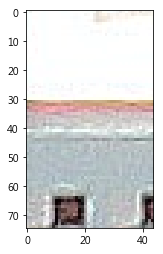

In [64]:
plt.imshow(img[303:378, 212:256] )
plt.show()

In [65]:
ALL=[]
imgw_h_range=20

In [66]:
for all_ob in ALL_OBJRCT1:
    #print(all_ob)
    if abs((all_ob[2][1]-all_ob[2][0])-(all_ob[4][1]-all_ob[4][0]))<imgw_h_range:
        ALL.append(all_ob)

In [67]:
ALL

[['方標 0.94',
  'y:(top, bottom)',
  (120, 149),
  'x:(left, right)',
  (384, 414),
  'IOU值:',
  0.93665904],
 ['方標 0.95',
  'y:(top, bottom)',
  (119, 149),
  'x:(left, right)',
  (352, 379),
  'IOU值:',
  0.94905776],
 ['方標 0.97',
  'y:(top, bottom)',
  (121, 148),
  'x:(left, right)',
  (317, 347),
  'IOU值:',
  0.97170836],
 ['方標 0.99',
  'y:(top, bottom)',
  (121, 148),
  'x:(left, right)',
  (282, 311),
  'IOU值:',
  0.9872896],
 ['方標 0.65',
  'y:(top, bottom)',
  (396, 420),
  'x:(left, right)',
  (331, 357),
  'IOU值:',
  0.6495855],
 ['方標 0.78',
  'y:(top, bottom)',
  (396, 420),
  'x:(left, right)',
  (270, 296),
  'IOU值:',
  0.78007686],
 ['方標 0.86',
  'y:(top, bottom)',
  (393, 421),
  'x:(left, right)',
  (362, 386),
  'IOU值:',
  0.8600781],
 ['方標 0.89',
  'y:(top, bottom)',
  (397, 419),
  'x:(left, right)',
  (302, 325),
  'IOU值:',
  0.8881658],
 ['方標 0.93',
  'y:(top, bottom)',
  (365, 391),
  'x:(left, right)',
  (330, 357),
  'IOU值:',
  0.92643094],
 ['方標 0.96',
  'y:(top,

In [68]:
out=[]

In [69]:
for i,all_print1 in enumerate (ALL):
    #print(all_print1)
    for ii,all_print2 in enumerate (ALL):
        if all_print1[4][0]<all_print2[4][0] and all_print1[4][1]>all_print2[4][1] and all_print1[2][0]<all_print2[2][0] and all_print1[2][1]>all_print2[2][1]:
            print('1',all_print1)
            out.append(all_print1)
            
        elif all_print1[4][0]<all_print2[4][0] and all_print1[4][1]>all_print2[4][1]and all_print1[2][0]<all_print2[2][0] and all_print1[2][1]>all_print2[2][0]:       
            print('2',all_print1)
            out.append(all_print1)
            


In [70]:
out

[]

In [71]:
for out_del in out:
    print(all_print)
    ALL.remove(out_del)

In [72]:
ALL

[['方標 0.94',
  'y:(top, bottom)',
  (120, 149),
  'x:(left, right)',
  (384, 414),
  'IOU值:',
  0.93665904],
 ['方標 0.95',
  'y:(top, bottom)',
  (119, 149),
  'x:(left, right)',
  (352, 379),
  'IOU值:',
  0.94905776],
 ['方標 0.97',
  'y:(top, bottom)',
  (121, 148),
  'x:(left, right)',
  (317, 347),
  'IOU值:',
  0.97170836],
 ['方標 0.99',
  'y:(top, bottom)',
  (121, 148),
  'x:(left, right)',
  (282, 311),
  'IOU值:',
  0.9872896],
 ['方標 0.65',
  'y:(top, bottom)',
  (396, 420),
  'x:(left, right)',
  (331, 357),
  'IOU值:',
  0.6495855],
 ['方標 0.78',
  'y:(top, bottom)',
  (396, 420),
  'x:(left, right)',
  (270, 296),
  'IOU值:',
  0.78007686],
 ['方標 0.86',
  'y:(top, bottom)',
  (393, 421),
  'x:(left, right)',
  (362, 386),
  'IOU值:',
  0.8600781],
 ['方標 0.89',
  'y:(top, bottom)',
  (397, 419),
  'x:(left, right)',
  (302, 325),
  'IOU值:',
  0.8881658],
 ['方標 0.93',
  'y:(top, bottom)',
  (365, 391),
  'x:(left, right)',
  (330, 357),
  'IOU值:',
  0.92643094],
 ['方標 0.96',
  'y:(top,

In [73]:
from PIL import Image, ImageFont, ImageDraw

for draw_all in ALL:
    plt_all=[(draw_all[4][0], draw_all[2][0]),(draw_all[4][1], draw_all[2][1])]
    font = ImageFont.truetype(font='font/msjh.ttc',
                        size=np.floor(3e-2 * 300 + 0.4).astype('int32'))
    draw1 = ImageDraw.Draw(image)
    label_size = draw1.textsize(draw_all[0], font)
    
    if draw_all[2][0] - label_size[1] >= 0:
        text_origin = np.array([draw_all[4][0], draw_all[2][0] - label_size[1]])
    else:
        text_origin = np.array([draw_all[4][0], draw_all[2][0]+1 ])
        
    # create rectangle image 
    img1 = ImageDraw.Draw(image1)   
    img1.rectangle(plt_all,  outline ="red") 
    img1.rectangle([tuple(text_origin), tuple(text_origin + label_size)],
                    fill=(255,0,0))
    draw1 = ImageDraw.Draw(image1)
    draw1.text((text_origin), draw_all[0], fill=(0, 0, 0),font=font)

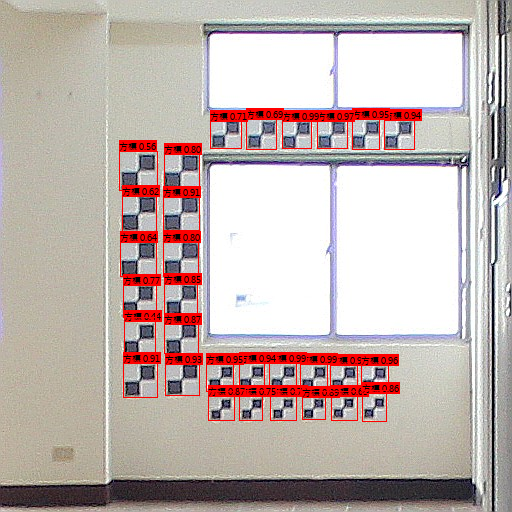

In [74]:
image1

In [ ]:
image1.save('Path to dets txt/result/img20m.png', quality=90)

In [ ]:
for ALL_OBJRCT1_1 in ALL:
    print(ALL_OBJRCT1_1)

In [ ]:
List_box_Posttion=[]
List_Score=[]

In [ ]:
for all_ob in ALL:
    post=[all_ob[4][0],all_ob[2][0],all_ob[4][1],all_ob[2][1]]
    List_box_Posttion.append(post)
    List_Score.append(all_ob[6])

In [ ]:
import os
import numpy as np

from yolo3.voc_eval import voc_eval   # 注意將voc_eval.py和compute_mAP.py放在同一級目錄下
class_name_list=[]
Boxes_List=[]
detpath = 'Path to dets txt'   # 各類txt文件路徑
detfiles = os.listdir(detpath)
current_path = os.getcwd()
results_path = current_path+"/Path to dets txt/test_xml"
sub_files = os.listdir(results_path)
for i in range(len(sub_files)):
    class_name = sub_files[i].split(".xml")[0]
    class_name_list.append(class_name)

In [ ]:
class_name_list

In [ ]:
Class_txt = open(current_path+'/'+detpath+'/class/'+class_name_list[0]+'.txt', 'w') 
for i,boxes_list_list in enumerate (List_box_Posttion):
    boxes_list_list.insert(0,class_name_list[0])
    boxes_list_list.insert(1,List_Score[i])
for _list in List_box_Posttion:
    _list_=" ".join('%s' %id for id in _list)
    Boxes_List.append(_list_)
for Box in Boxes_List:
    Class_txt.write(Box)
    Class_txt.write('\n')
Class_txt.close()

In [ ]:
List_Score

In [ ]:
sum(List_Score)/8